In [13]:
%matplotlib qt


(python:25755): Gtk-WARNING **: 21:35:29.589: Theme parsing error: gtk.css:22:17: 'gtk-icon-shadow' is not a valid property name


<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:98: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:100: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:98: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:100: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/i

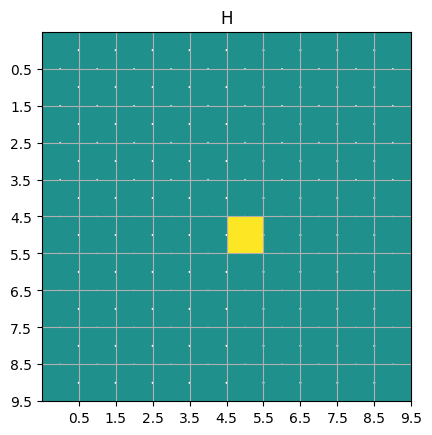

In [2]:
"""

The first section of the code contains setup and initialization 
information.  Leave it alone for now, and you can play with them later 
after you get the code filled in and running without bugs.  

"""

# Set up python environment.  numpy and matplotlib will have to be installed
# with the python installation.

import numpy
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.animation as animation
import math

# Grid and Variable Initialization -- stuff you might play around with

ncol = 10       # grid size (number of cells)
nrow = ncol

nSlices = 2000     # maximum number of frames to show in the plot
ntAnim = 10      # number of time steps for each frame

horizontalWrap = False # determines whether the flow wraps around, connecting
                       # the left and right-hand sides of the grid, or whether
                       # there's a wall there. 
interpolateRotation = True
rotationScheme = "PlusMinus"   # "WithLatitude", "PlusMinus", "Uniform"

# Note: the rotation rate gradient is more intense than the real world, so that
# the model can equilibrate quickly.

windScheme = ""  # "Curled", "Uniform"
initialPerturbation = "Tower"    # "Tower", "NSGradient", "EWGradient"
textOutput = False
plotOutput = True
arrowScale = 30

dT = 600 # seconds [original 600 s] #############
G = 9.8e-4 # m/s2, hacked (low-G) to make it run faster
HBackground = 4000 # meters

dX = 10.E3 # meters, small enough to respond quickly.  This is a very small ocean
# on a very small, low-G planet. [original 10.e3 m] ######### 

dxDegrees = dX / 110.e3
flowConst = G  # 1/s2
dragConst = 10.E-6  # about 10 days decay time
meanLatitude = 30 # degrees

# Here's stuff you probably won't need to change

latitude = []
rotConst = []
windU = []
for irow in range(0,nrow):
    if rotationScheme is "WithLatitude":
        latitude.append(meanLatitude + (irow - nrow/2) * dxDegrees)
        rotConst.append(-7.e-5 * math.sin(math.radians(latitude[-1]))) # s-1
    elif rotationScheme is "PlusMinus":
        rotConst.append(-3.5e-5 * (1. - 0.8 * (irow - (nrow-1)/2) / nrow)) # rot 50% +-
    elif rotationScheme is "Uniform":
        rotConst.append(-3.5e-5) 
    else:
        rotConst.append(0)

    if windScheme is "Curled":
        windU.append(1e-8 * math.sin( (irow+0.5)/nrow * 2 * 3.14 )) 
    elif windScheme is "Uniform":
        windU.append(1.e-8)
    else:
        windU.append(0)

itGlobal = 0

U = numpy.zeros((nrow, ncol+1))
V = numpy.zeros((nrow+1, ncol))
H = numpy.zeros((nrow, ncol+1))
dUdT = numpy.zeros((nrow, ncol))
dVdT = numpy.zeros((nrow, ncol))
dHdT = numpy.zeros((nrow, ncol))
dHdX = numpy.zeros((nrow, ncol+1))
dHdY = numpy.zeros((nrow, ncol))
dUdX = numpy.zeros((nrow, ncol))
dVdY = numpy.zeros((nrow, ncol))
rotV = numpy.zeros((nrow,ncol)) # interpolated to u locations
rotU = numpy.zeros((nrow,ncol)) #              to v
# For U rotation interpolation
inter_u = numpy.zeros((nrow,ncol))
# For V rotation interpolation
inter_v = numpy.zeros((nrow,ncol))

midCell = int(ncol/2)
if initialPerturbation is "Tower":
    H[midCell,midCell] = 1
elif initialPerturbation is "NSGradient":
    H[0:midCell,:] = 0.1
elif initialPerturbation is "EWGradient":
    H[:,0:midCell] = 0.1

"""
This is the work-horse subroutine.  It steps forward in time, taking ntAnim steps of
duration dT.  
"""
###############################################################
def animStep():    
    global stepDump, itGlobal

    for time in range(0,ntAnim):
        #### Longitudinal derivative ##########################
        # Calculate dHdX
        for ix in range(0, nrow-1):
            for iy in range(0, ncol-1):
                # Calculate the slope for X
                dHdX[ix,iy+1] = (H[ix,iy+1] - H[ix,iy]) / dX    

        # Calculate dUdX
        for ix in range(0, nrow):
            for iy in range(0, ncol):     
                # Calculate the difference in U
                dUdX[ix,iy] = (U[ix,iy+1] - U[ix,iy]) / dX
        ########################################################
        #### Latitudinal derivative ############################
        # Calculate dHdY
        dHdY[0,:] = 0 # The top boundary gradient dHdY set to zero
        for ix in range(0, nrow-1): # NOTE: the top row is zero
            for iy in range(0, ncol):
                # Calculate the slope for Y
                dHdY[ix+1,iy] = (H[ix+1,iy] - H[ix, iy]) / dX
        # Calculate dVdY
        for ix in range(0, nrow):
            for iy in range(0, ncol):
                # Calculate the difference in V
                dVdY[ix,iy] = (V[ix+1,iy] - V[ix,iy]) / dX
        #########################################################
        #### Rotational terms ###################################
        ## Interpolate to cell centers for U and V ##
        if interpolateRotation is True:
            # Average and rotate
            # Temporary u for rotation
            for ix in range(0,nrow):
                for iy in range(0,ncol):
                    inter_u[ix,iy] = ((U[ix,iy] + U[ix,iy+1]) / 2) * rotConst[ix]
            # Temporary v for rotation
            for ix in range(0,nrow):
                for iy in range(0,ncol):
                    inter_v[ix,iy] = ((V[ix,iy] + V[ix+1,iy]) / 2) * rotConst[ix]
            # New rotV
            for ix in range(0,nrow):
                for iy in range(0,ncol-1):        
                    rotV[ix,iy+1] = ((inter_v[ix,iy] + inter_v[ix,iy+1]) / 2)        
            # New rotU
            for ix in range(0,nrow-1):
                for iy in range(0,ncol):
                    rotU[ix+1,iy] = ((inter_u[ix,iy] + inter_u[ix+1,iy]) / 2)      
            if horizontalWrap is True:
                rotV[:,0] = (rotV[:,0] + rotV[:,ncol-1])/2
            else:
                rotV[:,0] = 0 # Left most column


        ## Or without interpolation ##
        else:
            for ix in range(0, nrow):
                for iy in range(0, ncol):
                    rotU[ix,iy] = rotConst[ix] * U[ix,iy] # Interpolated to U
                    rotV[ix,iy] = rotConst[ix] * V[ix,iy] # Interpolated to V

        ##########################################################  
        #### Time derivatives ####################################
        ## dUdT
        for ix in range(0, nrow):
            for iy in range(0, ncol):
                dUdT[ix,iy] = (rotV[ix,iy]) - (flowConst * dHdX[ix,iy]) - (dragConst * U[ix,iy]) + windU[ix]
        ## dVdT
        for ix in range(0, nrow):
            for iy in range(0, ncol):       
                dVdT[ix,iy] = (-rotU[ix,iy]) - (flowConst * dHdY[ix,iy]) - (dragConst * V[ix,iy])
        ## dHdT  
        for ix in range(0, nrow):
            for iy in range(0, ncol):
                dHdT[ix,iy] = -(dUdX[ix,iy] + dVdY[ix,iy]) * (HBackground / dX)   

        # Step Forward One Time Step
        for ix in range(0,nrow):
            for iy in range(0,ncol):
                U[ix,iy] = U[ix,iy] + (dUdT[ix,iy] * dT)
        for ix in range(0,nrow):
            for iy in range(0,ncol):
                V[ix,iy] = V[ix,iy] + (dVdT[ix,iy] * dT)
        for ix in range(0,nrow):
            for iy in range(0,ncol):
                H[ix,iy] = H[ix,iy] + (dHdT[ix,iy] * dT)
        ###########################################################        
        #### Maintain the ghost cells #############################
        # North wall velocity zero  
        V[0,:] = 0 # North wall is zero
        V[nrow,:] = 0 # South wall is zero

        # Horizontal wrapping
        if horizontalWrap is True:
            U[:,ncol] = U[:,0]
            H[:,ncol] = H[:,0]
        else:
            U[:,0] = 0
            U[:,ncol-1] = 0


    itGlobal = itGlobal + ntAnim
###################################################################

def firstFrame():
    global fig, ax, hPlot
    fig, ax = plt.subplots()
    ax.set_title("H")   
    hh = H[:,0:ncol]
    loc = tkr.IndexLocator(base=1, offset=1)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    grid = ax.grid(which='major', axis='both', linestyle='-')
    hPlot = ax.imshow(hh, interpolation='nearest', clim=(-0.5,0.5))   
    plotArrows()
    plt.show(block=False)


def plotArrows():
    global quiv, quiv2
    xx = []
    yy = []
    uu = []
    vv = []
    for irow in range( 0, nrow ):
        for icol in range( 0, ncol ):
            xx.append(icol - 0.5)
            yy.append(irow )
            uu.append( U[irow,icol] * arrowScale )
            vv.append( 0 )
    quiv = ax.quiver( xx, yy, uu, vv, color='white', scale=1)
    for irow in range( 0, nrow ):
        for icol in range( 0, ncol ):
            xx.append(icol)
            yy.append(irow - 0.5)
            uu.append( 0 )
            vv.append( -V[irow,icol] * arrowScale )
    quiv2 = ax.quiver( xx, yy, uu, vv, color='white', scale=1)

def updatefig(*args):
    global hPlot, quiv, quiv2
    animStep()
    hh = H[:,0:ncol]
    hPlot.set_array(hh)
    xx = []
    yy = []
    uu = []
    vv = []
    for irow in range( 0, nrow ):
        for icol in range( 0, ncol ):
            xx.append(icol - 0.5)
            yy.append(irow )
            uu.append( U[irow,icol] * arrowScale )
            vv.append( 0 )
    quiv.set_UVC(uu,vv)
    for irow in range( 0, nrow ):
        for icol in range( 0, ncol ):
            xx.append(icol)
            yy.append(irow - 0.5)
            uu.append( 0 )
            vv.append( -V[irow,icol] * arrowScale )
    quiv2.set_UVC(uu,vv)
    return hPlot, quiv, quiv2

firstFrame()
ani = animation.FuncAnimation(fig, updatefig, frames=600, interval=10, blit=True)
ani.save('shallowWater.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()